In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [2]:
image_path = 'C:/Users/pirat/Desktop/New folder (4) - Copy/fracture'

In [3]:
data = pd.read_csv("encoded-advise.csv")
data.head()

,images,advice
0,f (1).jpg,The patient is allowed partial weight-bearing ...
1,f (2).jpg,The patient should be advised to use crutches ...
2,f (3).jpg,The patient should be advised to use crutches ...
3,f (4).jpg,The patient should be advised to use crutches ...
4,f (5).jpg,The fracture should be corrected by using inte...


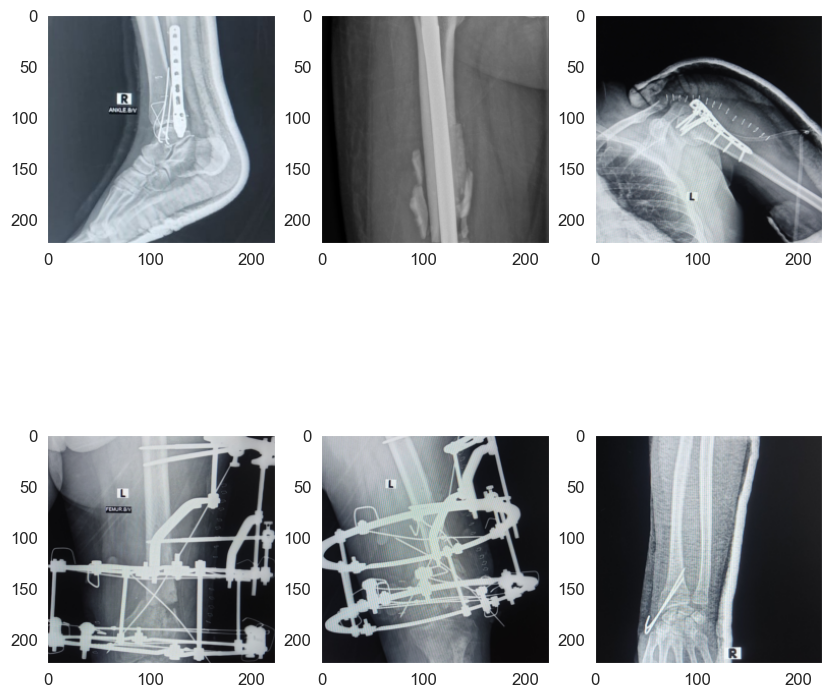

In [4]:
#load the image information
from tensorflow.keras.preprocessing.image import load_img,img_to_array

def load_data(): # return all image file path and name
    import glob
    file_name = []
    file_path= os.path.join('C:/Users/pirat/Desktop/New folder (4) - Copy/fracture', '*')
    
    for filename in sorted(glob.glob(file_path)):
        file_name.append(filename)

    file_name = np.asarray(file_name)
    return file_name

def readImage(path,img_size=299):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size),interpolation='bilinear',keep_aspect_ratio=True)
    img = img_to_array(img)
    img = img/255.
    
    return img

# call the load_data function and test if they work

file_name = load_data()
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
axs = axs.flatten()
for i in range(6):
    img = readImage(file_name[i],224)
    axs[i].imshow(img)

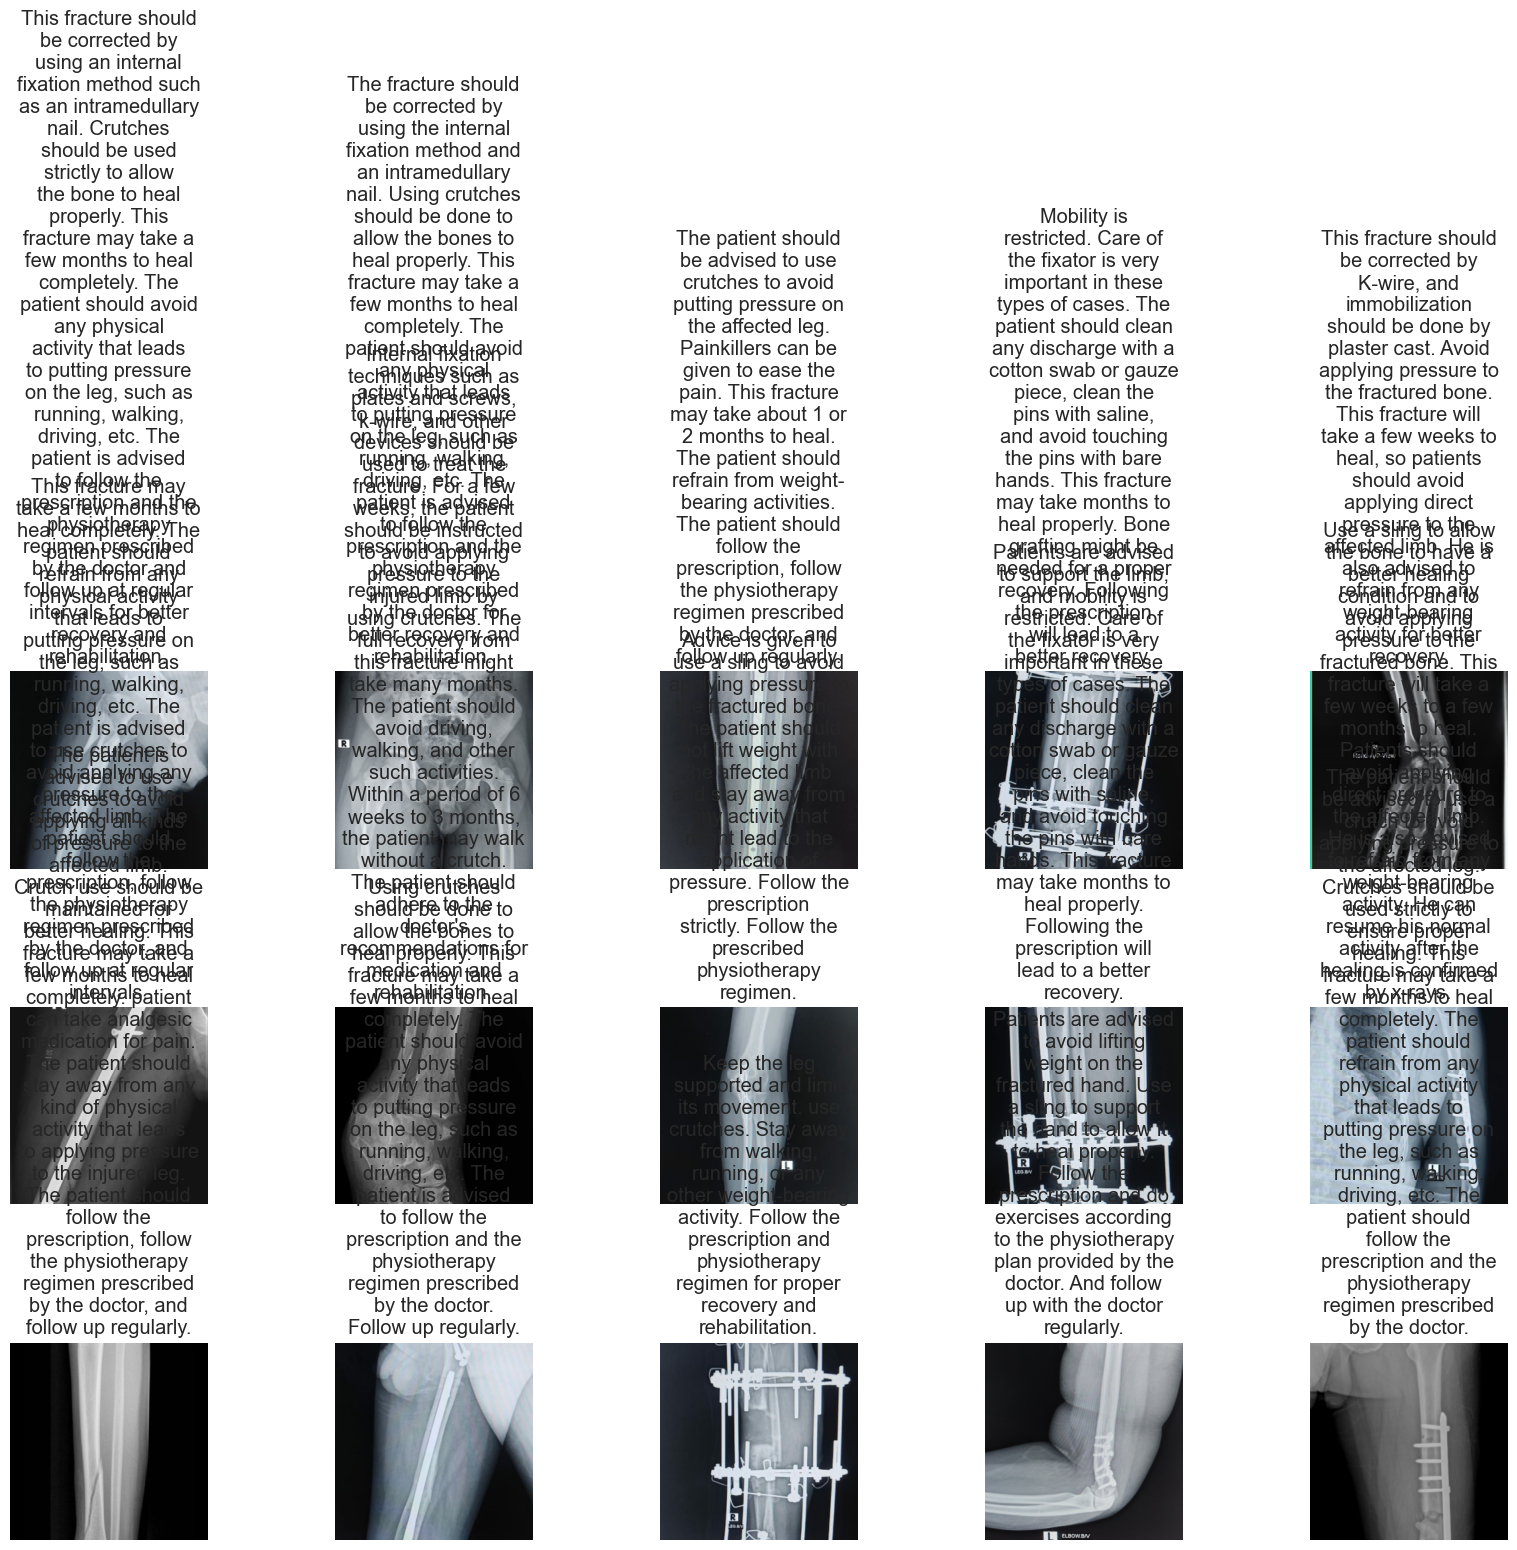

In [5]:
#Display image - code from https://www.kaggle.com/code/quadeer15sh/flickr8k-image-captioning-using-cnns-lstms
# display 15 images with the first caption from the metadata
def display_images(temp_df):
    from textwrap import wrap
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"C:/Users/pirat/Desktop/New folder (4) - Copy/fracture/{temp_df.images[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.advice[i], 20)))
        plt.axis("off")
        
display_images(data.sample(15))

In [6]:
def text_preprocessing(data):
    data['advice'] = data['advice'].apply(lambda x: x.lower()) # convert sentences into lowercase
    data['advice'] = data['advice'].apply(lambda x: x.replace("[^A-Za-z]","")) # remove all character that is not a-z (remove punctation and number character)
    #data['caption'] = data['caption'].apply(lambda x: x.replace('is', "").replace('are',"")) #remove 'is' and 'are'
    data['advice'] = data['advice'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1])) # remove single character
    data['advice'] = "startseq "+data['advice']+" endseq" # added header - startseq and footer -endseq to each caption
    return data

data = text_preprocessing(data)
images = data['images'].unique().tolist()
nimages = len(images)
captions = data['advice'].tolist()
ncaptions = len(captions)
print('Total number of image are :'+ str(nimages))
print('Total caption length are : '+str(ncaptions))
captions[:10]

Total number of image are :331
Total caption length are : 331


['startseq the patient is allowed partial weight-bearing with crutches until the fractures have healed. this usually takes about 6–12 weeks. patient should avoid applying pressure to the fractured limb. and follow the prescription and physiotherapy regimen prescribed by the doctor. endseq',
 'startseq the patient should be advised to use crutches to avoid putting pressure on the affected leg. this fracture may take about or months to heal. the patient should follow the prescription, follow the physiotherapy regimen prescribed by the doctor, and follow up regularly. endseq',
 'startseq the patient should be advised to use crutches to avoid putting pressure on the affected leg. crutch use should be maintained strictly to ensure proper healing. this fracture may take few months to heal completely. the patient should refrain from any physical activity that leads to putting pressure on the leg, such as running, walking, driving, etc. the patient should follow the prescription, follow the ph

In [7]:
def cap_generator_dict(data):
    caption_dict = {}
    all_caption = []

    for _, row in data.iterrows():
        image_id = row['images']
        caption = row['advice']

        # Store the caption in the caption_dict based on the image ID
        if image_id not in caption_dict:
            caption_dict[image_id] = []
        caption_dict[image_id].append(caption)

        # Save the caption in the all_caption list
        all_caption.append(caption)

    return caption_dict, all_caption

In [8]:
caption_dict, all_caption = cap_generator_dict(data)

# Access captions for a specific image ID from the caption_dict
image_id = 'f (5).jpg'

# print all captions for this image
print (caption_dict[image_id])
# Print length of total caption 
print(len(all_caption))

['startseq the fracture should be corrected by using internal fixation methods such as plates, screws, and k-wire. the patient should be advised to use crutches to avoid applying pressure to the affected leg for few weeks. this fracture may take few months to heal completely. patient should refrain from running, walking, driving, etc. the patient can walk without crutches within 6- to 3-month period. the patient should follow the prescription, follow the physiotherapy regimen prescribed by the doctor, and follow up regularly. endseq']
331


In [9]:
import random
#train validation test split - 80% train 10% validation 10% test
image_id = list(caption_dict.keys())

random.shuffle(image_id)

train_split = int(len(image_id) * 0.8)
test_split = int(len(image_id) * 0.85)

train = image_id[:train_split]
test = image_id[train_split:test_split]
validation = image_id[test_split:]

print("Train set size:", len(train))
print("Test set size:", len(test))
print("Validation set size:", len(validation))

Train set size: 264
Test set size: 17
Validation set size: 50


In [10]:
#tutorial from https://www.kaggle.com/code/satishgunjal/tokenization-in-nlp/notebook
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)

vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size (+1 for the padding token) 
max_length = max(len(caption.split()) for caption in captions) #biggest number of caption for the image

transforms_sequence = tokenizer.texts_to_sequences([captions[0]]) # child in pink dress climbing up set of stairs in an entry way
print(transforms_sequence)

sequence_to_text = tokenizer.sequences_to_texts(transforms_sequence)
print(sequence_to_text)

[[12, 1, 5, 15, 259, 314, 52, 81, 30, 38, 174, 1, 315, 158, 175, 14, 216, 316, 217, 317, 82, 5, 4, 11, 23, 7, 2, 1, 51, 32, 3, 6, 1, 18, 3, 24, 34, 50, 8, 1, 29, 13]]
['startseq the patient is allowed partial weight bearing with crutches until the fractures have healed this usually takes about 6–12 weeks patient should avoid applying pressure to the fractured limb and follow the prescription and physiotherapy regimen prescribed by the doctor endseq']


In [11]:
print(vocab_size)
print(max_length) 

524
111


In [12]:
from tensorflow.keras.applications import Xception
img_size = 299
features = {}
image_path = 'C:/Users/pirat/Desktop/New folder (4) - Copy/fracture'

# CNN (Xception) model to extract image features
cnn_model = Xception(weights='imagenet', include_top=False, pooling='avg')
#cnn_model.summary()

for image in tqdm(data['images'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = cnn_model.predict(img, verbose=0)
    features[image] = feature #Dictionary 'features' is created and will be loaded with the extracted features of image data

100%|████████████████████████████████████████████████████████████████████████████████| 331/331 [00:36<00:00,  9.09it/s]


In [13]:
# code based from https://www.kaggle.com/code/quadeer15sh/flickr8k-image-captioning-using-cnns-lstms/notebook
#https://www.kaggle.com/code/williamrenaldy/image-caption-generator/notebook
# https://www.analyticsvidhya.com/blog/2021/12/step-by-step-guide-to-build-image-caption-generator-using-deep-learning/
def data_generator(keys,caption_dict,features,tokenizer,max_length,vocab_size,batch_size):
    
    #x1 = images features
    #x2 = input caption text sequence
    #y = output caption textx sequence
    x1,x2,y = list(),list(),list()

    n = 0
    
    while True:
        for key in keys: # the train/test/split image id list
            n += 1
            
            # retrieve the 5 captions based on image id 
            captions = caption_dict[key]
            # process each caption
            for caption in captions:
                # encode and transform the text caption to a tokenized value
                seq = tokenizer.texts_to_sequences([caption])[0]

                # split the sequence into X, y pairs
                for i in range(1,len(seq)):
                    in_seq,out_seq = seq[:i],seq[i]

                    # pad the input sequence so all of them have the same input length
                    in_seq = pad_sequences([in_seq],maxlen=max_length)[0]
                    
                    # next word prediction - perform categorical
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]

                    x1.append(features[key][0])
                    x2.append(in_seq)
                    y.append(out_seq)
                    
            if n == batch_size:
                x1 = np.array(x1)
                x2 = np.array(x2)
                y = np.array(y)
                yield [[x1,x2],y]

                x1,x2,y = list(),list(),list()
                n = 0

In [14]:
# model code from https://www.kaggle.com/code/quadeer15sh/flickr8k-image-captioning-using-cnns-lstms/notebook
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Embedding, LSTM, Dense, Dropout, Reshape, concatenate, add
# Define input shapes
image_input_shape = (2048,)  # Assuming Xception extracts 2048-dimensional features
caption_input_shape = (max_length,)  # Assuming a fixed caption length

# Input placeholders for batch generator inputs
image_input = Input(shape=image_input_shape, name='image_input_layer')
caption_input = Input(shape=caption_input_shape, name='caption_input_layer')

#img_features = Dense(256, activation='relu')(image_input)  # change to leaku relu to fix ram issue, based from https://stackoverflow.com/questions/53683164/keras-occupies-an-indefinitely-increasing-amount-of-memory-for-each-epoch
img_features = Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(image_input)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

# Embedding layer
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(caption_input)
merged = concatenate([img_features_reshaped, sentence_features], axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.3))(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

# Create the model
model = Model(inputs=[image_input, caption_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input_layer (InputLayer)  [(None, 2048)]      0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['image_input_layer[0][0]']      
                                                                                                  
 caption_input_layer (InputLaye  [(None, 111)]       0           []                               
 r)                                                                                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']              

In [15]:
# https://stackoverflow.com/questions/46394574/keras-predict-memory-swap-increase-indefinitely
# https://stackoverflow.com/questions/53683164/keras-occupies-an-indefinitely-increasing-amount-of-memory-for-each-epoch
from tensorflow.keras.callbacks import Callback
import gc
from keras import backend as k
class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

In [16]:
epochs = 30

batch_size = 8

steps_per_epoch = len(train) // batch_size
validation_steps= len(validation) // batch_size

# Initialize empty lists to store accuracy and loss values
train_loss, val_loss = [], []

# Define the path where you want to save the model checkpoint, that also include timestamp
checkpoint_path = 'C:/Users/pirat/Desktop/New folder (4) - Copy-{val_loss:.2f}.h5'
# Create a ModelCheckpoint callback to save the best model during training
model_checkpoint_callback  = ModelCheckpoint(checkpoint_path,save_weights_only=True,monitor="val_loss",
                            mode="min",save_best_only=True)

for i in range(epochs):
    print("Epoch:", i+1)
    train_generator = data_generator(train,caption_dict,features,tokenizer,max_length,vocab_size,batch_size)
    validation_generator = data_generator(validation,caption_dict,features,tokenizer,max_length,vocab_size,batch_size)

    history = model.fit(train_generator,epochs=1,steps_per_epoch=steps_per_epoch,validation_data=validation_generator,validation_steps = validation_steps,callbacks=[model_checkpoint_callback,ClearMemory()])
    
    # Append the accuracy and loss values for this epoch to the lists
    train_loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])

Epoch: 1
33/33 [==============================] - 6s 104ms/step - loss: 5.2516 - val_loss: 4.6393
Epoch: 2
33/33 [==============================] - 3s 84ms/step - loss: 4.6025 - val_loss: 4.2585
Epoch: 3
33/33 [==============================] - 3s 84ms/step - loss: 4.1424 - val_loss: 3.6635
Epoch: 4
33/33 [==============================] - 3s 84ms/step - loss: 3.5459 - val_loss: 2.9640
Epoch: 5
33/33 [==============================] - 3s 84ms/step - loss: 2.9371 - val_loss: 2.4461
Epoch: 6
33/33 [==============================] - 3s 85ms/step - loss: 2.4777 - val_loss: 2.0585
Epoch: 7
33/33 [==============================] - 3s 84ms/step - loss: 2.1331 - val_loss: 1.8289
Epoch: 8
33/33 [==============================] - 3s 85ms/step - loss: 1.8708 - val_loss: 1.5724
Epoch: 9
33/33 [==============================] - 3s 84ms/step - loss: 1.6332 - val_loss: 1.4131
Epoch: 10
33/33 [==============================] - 3s 85ms/step - loss: 1.4692 - val_loss: 1.3163
Epoch: 11
33/33 [===========

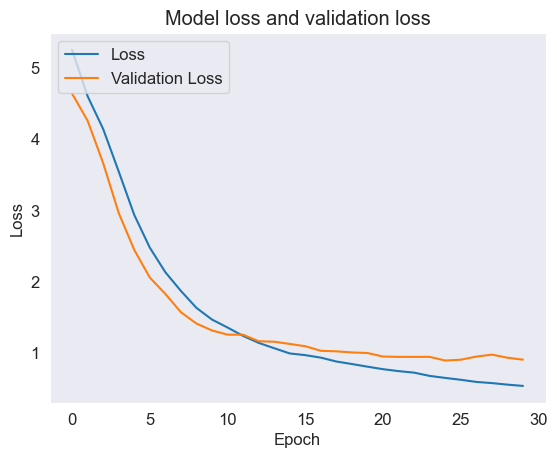

In [17]:
plt.plot(train_loss)
plt.plot(val_loss)

plt.title('Model loss and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [18]:
# this function make sure that an 
def index_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [19]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = index_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [20]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = caption_dict[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  6%|████▉                                                                              | 1/17 [00:03<00:57,  3.62s/it]

BLEU-1: 0.380952
BLEU-2: 0.166957


 12%|█████████▊                                                                         | 2/17 [00:09<01:17,  5.16s/it]

BLEU-1: 0.536585
BLEU-2: 0.446718


 18%|██████████████▋                                                                    | 3/17 [00:15<01:17,  5.56s/it]

BLEU-1: 0.537688
BLEU-2: 0.419013


 24%|███████████████████▌                                                               | 4/17 [00:21<01:11,  5.52s/it]

BLEU-1: 0.531599
BLEU-2: 0.410496


 29%|████████████████████████▍                                                          | 5/17 [00:25<00:59,  4.92s/it]

BLEU-1: 0.536050
BLEU-2: 0.402717


 35%|█████████████████████████████▎                                                     | 6/17 [00:29<00:50,  4.55s/it]

BLEU-1: 0.524562
BLEU-2: 0.385047


 41%|██████████████████████████████████▏                                                | 7/17 [00:38<01:00,  6.01s/it]

BLEU-1: 0.506329
BLEU-2: 0.381163


 47%|███████████████████████████████████████                                            | 8/17 [00:44<00:55,  6.18s/it]

BLEU-1: 0.531418
BLEU-2: 0.417415


 53%|███████████████████████████████████████████▉                                       | 9/17 [00:48<00:43,  5.41s/it]

BLEU-1: 0.518212
BLEU-2: 0.399228


 59%|████████████████████████████████████████████████▏                                 | 10/17 [00:55<00:40,  5.82s/it]

BLEU-1: 0.521106
BLEU-2: 0.395291


 65%|█████████████████████████████████████████████████████                             | 11/17 [01:01<00:36,  6.04s/it]

BLEU-1: 0.494163
BLEU-2: 0.370399


 71%|█████████████████████████████████████████████████████████▉                        | 12/17 [01:07<00:30,  6.11s/it]

BLEU-1: 0.526995
BLEU-2: 0.408512


 76%|██████████████████████████████████████████████████████████████▋                   | 13/17 [01:14<00:25,  6.30s/it]

BLEU-1: 0.542735
BLEU-2: 0.428322


 82%|███████████████████████████████████████████████████████████████████▌              | 14/17 [01:20<00:18,  6.33s/it]

BLEU-1: 0.529470
BLEU-2: 0.415902


 88%|████████████████████████████████████████████████████████████████████████▎         | 15/17 [01:27<00:12,  6.38s/it]

BLEU-1: 0.542650
BLEU-2: 0.430360


 94%|█████████████████████████████████████████████████████████████████████████████▏    | 16/17 [01:34<00:06,  6.58s/it]

BLEU-1: 0.526891
BLEU-2: 0.413513


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [01:40<00:00,  5.94s/it]

BLEU-1: 0.513747
BLEU-2: 0.399404


In [21]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
  
    img_path = os.path.join('C:/Users/pirat/Desktop/New folder (4) - Copy/fracture', image_name)
    image = Image.open(img_path)
    captions = caption_dict[image_name]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_name], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq this fracture should be corrected by k-wire, and immobilization should be done by plaster cast. avoid applying pressure to the fractured bone. this fracture will take few weeks to heal, so patients should avoid applying direct pressure to the affected limb. he is also advised to refrain from any weight-bearing activity for better recovery. endseq
--------------------Predicted--------------------
startseq this fracture should be corrected by using internal fixation methods such as plates and screws the patient is advised not to put any kind of pressure on the affected limb avoid lifting weight on the fractured hand the patient can resume normal activity when healing is confirmed by x rays follow the prescription and do exercises according to the physiotherapy plan provided by the doctor endseq
---------------------Actual---------------------
startseq using crutches should be done to allow the bones to heal properly. this fracture

--------------------Predicted--------------------
startseq patients are advised to avoid applying pressure to the affected limb support the leg and avoid applying pressure to the leg care of the fixator is very important in these types of cases the patient should clean any discharge with cotton swab or gauze piece clean the pins with saline and avoid touching the pins with bare hands this fracture may take months to heal properly following the prescription and physiotherapy regimen is mandatory for full recovery endseq
---------------------Actual---------------------
startseq this fracture can be treated either by strapping the fractured finger to healthy one or by internal fixation. the patient is restricted from lifting weights or applying pressure to the fractured limb. the patient should follow the prescription and the physiotherapy regimen for proper rehabilitation. endseq
--------------------Predicted--------------------
startseq this fracture should be corrected by internal fixa

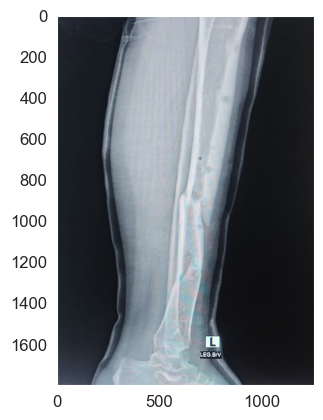

In [25]:
# display 15 images from the testing data

draws = random.sample(range(len(test)), 15)
for draw in draws:
    image_id = str(test[draw])
    generate_caption(image_id)